# Alkali opacity tutorial
This tutorial shows how to create Alkali opacity objects and compute their extinction coefficient spectra for a given atmospheric profile.

<div class="alert alert-info">

Note

You can also find this tutorial as a [Python script here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_alkali.py) or as a [jupyter notebook here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_alkali.ipynb).

</div>

In [1]:
# Lets start by importing some necessary modules:
import pyratbay.atmosphere as pa
import pyratbay.constants as pc
import pyratbay.opacity as op
import pyratbay.spectrum as ps

import matplotlib.pyplot as plt
import numpy as np

### Initialization
We will sample the models over a wavelength array and over an atmospheric profile. Lets create these first:

In [2]:
# We will sample the opacity over a constant-resolution wavelength array
# (values have micron units)
wl_min = 0.5
wl_max = 1.0
resolution = 30000.0
wl = ps.constant_resolution_spectrum(wl_min, wl_max, resolution)

# Atmospheric pressure profile in bars:
nlayers = 81
pressure = pa.pressure('1e-8 bar', '1e2 bar', nlayers)

# Initialize a Na model:
sodium = op.alkali.SodiumVdW(pressure, wl=wl)

In [3]:
# A print() call shows some useful info about the object
print(sodium)

Model name (name): 'sodium_vdw'
Model species (species): Na
Species mass (mass, amu): 22.989769
Profile hard cutoff from line center (cutoff, cm-1): 4500.0
Detuning parameter (detuning): 30.0
Lorentz-width parameter (lpar): 0.071
Partition function (Z): 2.0
Wavenumber  Wavelength          gf   Lower-state energy
      cm-1          um               cm-1
      (wn)                    (gf)   (elow)
  16960.87    0.589592   6.546e-01   0.000e+00
  16978.07    0.588995   1.309e+00   0.000e+00
Wavenumber (wn, cm-1):
   [20000.00 19999.33 19998.67 ... 10000.81 10000.47 10000.14]
Pressure (pressure, bar):
[1.000e-08 1.334e-08 1.778e-08 2.371e-08 3.162e-08 4.217e-08 5.623e-08
 7.499e-08 1.000e-07 1.334e-07 1.778e-07 2.371e-07 3.162e-07 4.217e-07
 5.623e-07 7.499e-07 1.000e-06 1.334e-06 1.778e-06 2.371e-06 3.162e-06
 4.217e-06 5.623e-06 7.499e-06 1.000e-05 1.334e-05 1.778e-05 2.371e-05
 3.162e-05 4.217e-05 5.623e-05 7.499e-05 1.000e-04 1.334e-04 1.778e-04
 2.371e-04 3.162e-04 4.217e-04 5.623e-0

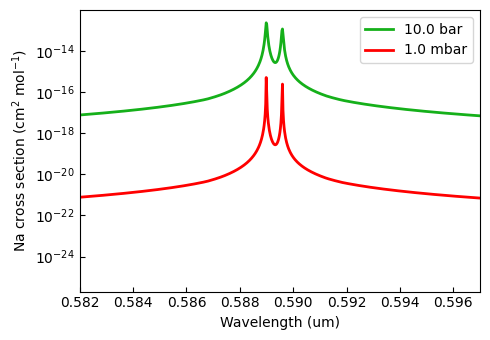

In [4]:
# Evaluate the cross_section over an isothermal profile
temperature = np.tile(1800.0, nlayers)
Na_cross_section = sodium.calc_cross_section(temperature)


# Show the spectra at a couple of layers
fig = plt.figure(2)
fig.set_size_inches(5.0, 3.5)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, Na_cross_section[72], color='xkcd:green', lw=2.0, label='10.0 bar')
ax.plot(wl, Na_cross_section[40], color='red', lw=2.0, label='1.0 mbar')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlim(0.582, 0.597)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Na cross section (cm$^{2}$ mol$^{-1}$)')
ax.legend(loc='upper right')
plt.tight_layout()

### Extinction coefficient
For radiative-transfer calculations we need the extinction coefficient, for which we need first number density profiles of the species.  Here we first simulate a simple atmosphere in thermochemical equilibrium to compute the number densities under the ideal gas law:


Compute chemical abundances.


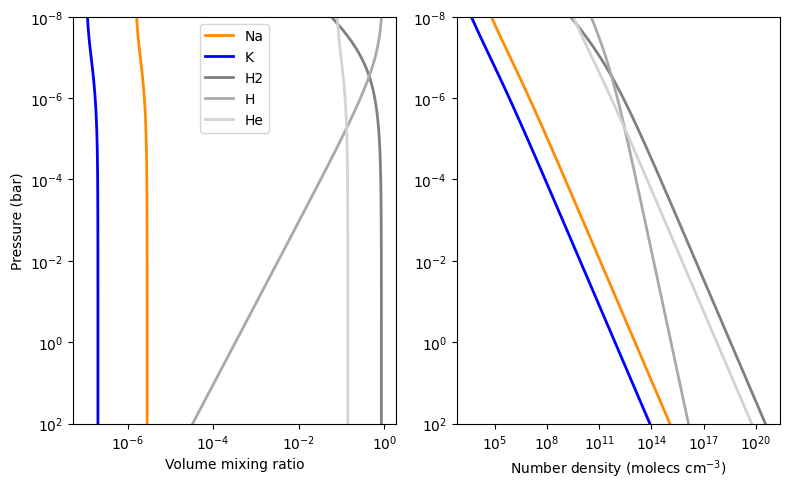

In [5]:
# A very simple atmosphere with solar abundance in thermochemical equilibrium
species = ['Na', 'K', 'H2', 'H', 'He']
net = pa.chemistry('tea', pressure, temperature, species)
# Number-density profiles under IGL (molecules per cm3)
number_densities = pa.ideal_gas_density(net.vmr, pressure, temperature)

Na_number_density = number_densities[:,0]
K_number_density = number_densities[:,1]


# Show profiles:
cols = ['darkorange', 'blue', 'gray', 'darkgray', 'lightgray']
plt.figure(1, (8,5))
plt.clf()
ax = plt.subplot(121)
for i, spec in enumerate(species):
    ax.plot(net.vmr[:,i], pressure, color=cols[i], lw=2.0, label=spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(100, 1e-8)
ax.set_xlabel('Volume mixing ratio')
ax.set_ylabel('Pressure (bar)')
ax.legend(loc='best')

ax = plt.subplot(122)
for i, spec in enumerate(species):
    ax.plot(number_densities[:,i], pressure, color=cols[i], lw=2.0, label=spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(100, 1e-8)
ax.set_xlabel('Number density (molecs cm$^{-3}$)')
plt.tight_layout()

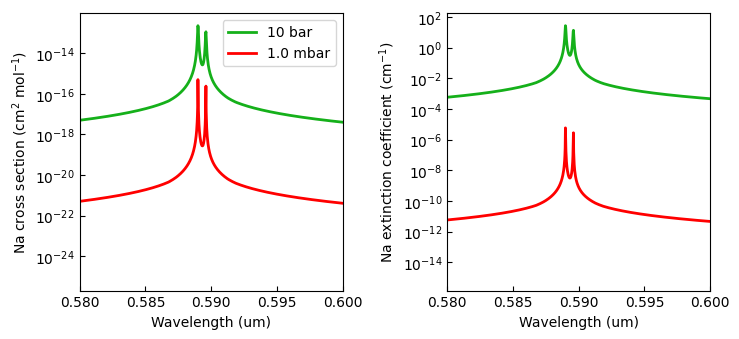

In [6]:
# Extinction-coefficient over the atmospheric profile
Na_extinction = sodium.calc_extinction_coefficient(
    temperature,
    Na_number_density,
)


# Show the spectra at a couple of layers
fig = plt.figure(2)
fig.set_size_inches(7.5, 3.5)
plt.clf()
ax = plt.subplot(121)
ax.plot(wl, sodium.cross_section[72], color='xkcd:green', lw=2.0, label='10 bar')
ax.plot(wl, sodium.cross_section[40], color='red', lw=2.0, label='1.0 mbar')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlim(0.58, 0.60)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Na cross section (cm$^{2}$ mol$^{-1}$)')
ax.legend(loc='upper right')

ax = plt.subplot(122)
ax.plot(wl, Na_extinction[72], color='xkcd:green', lw=2.0)
ax.plot(wl, Na_extinction[40], color='red', lw=2.0)
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlim(0.58, 0.60)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Na extinction coefficient (cm$^{-1}$)')
plt.tight_layout()

### Sodium and Potassium models

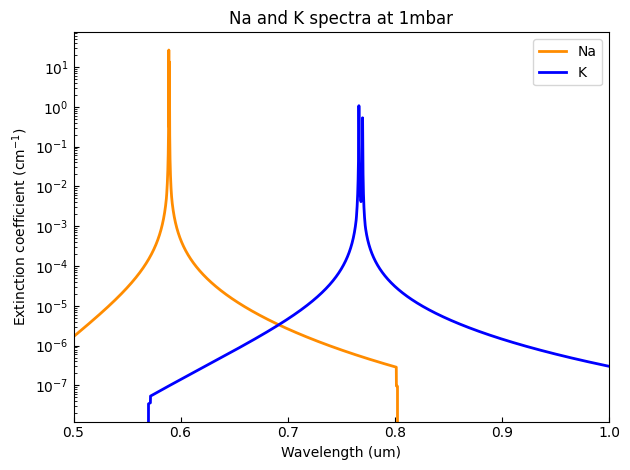

In [7]:
# Similarly, we can compute K extinction coefficients
potassium = op.alkali.PotassiumVdW(pressure, wl=wl)
K_extinction = potassium.calc_extinction_coefficient(
    temperature, K_number_density,
)

# Plot K extinction along Na's
fig = plt.figure(3)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, Na_extinction[72], color='darkorange', lw=2.0, label='Na')
ax.plot(wl, K_extinction[72], color='blue', lw=2.0, label='K')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlim(0.5, 1.0)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Extinction coefficient (cm$^{-1}$)')
ax.legend(loc='upper right')
ax.set_title('Na and K spectra at 1mbar')
plt.tight_layout()

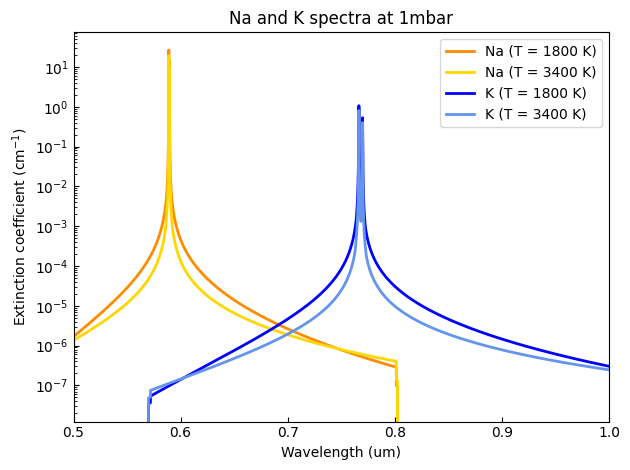

In [8]:
# To evaulate under new atmospheric conditions, simply call the
# extinction_coefficient() method with the new values:

# A hotter atmosphere
temp_hot = np.tile(3400.0, nlayers)
vmr_hot = net.thermochemical_equilibrium(temperature=temp_hot)
density_hot = pa.ideal_gas_density(vmr_hot, pressure, temp_hot)
Na_density_hot = density_hot[:,0]
K_density_hot = density_hot[:,1]

# New opacities
Na_extinction_hot = sodium.calc_extinction_coefficient(
    temp_hot, Na_density_hot,
)
K_extinction_hot = potassium.calc_extinction_coefficient(
    temp_hot, K_density_hot,
)


# Plot Na and K opacities
fig = plt.figure(4)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, Na_extinction[72], color='darkorange', lw=2.0, label='Na (T = 1800 K)')
ax.plot(wl, Na_extinction_hot[72], color='gold', lw=2.0, label='Na (T = 3400 K)')
ax.plot(wl, K_extinction[72], color='blue', lw=2.0, label='K (T = 1800 K)')
ax.plot(wl, K_extinction_hot[72], color='cornflowerblue', lw=2.0, label='K (T = 3400 K)')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlim(0.5, 1.0)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Extinction coefficient (cm$^{-1}$)')
ax.legend(loc='upper right')
ax.set_title('Na and K spectra at 1mbar')
plt.tight_layout()